# SOHO analysis 
The purpose of this notebook is to analysis visual-spectrum images of the sun from the SDO imaging satellite at the L1 Lagrange point (meaning the images are from the same perspective as the Earth) and use this data to determine the rotational period of the sun.

In [1]:
#imports
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

from utils.data import *
from utils.image_processing import detect_sunspots
from utils.feature_tracking import SunspotTracker
from utils.visualization import show_sunspot_images

# Data fetching

---

First thing, we are going to access the SOHO databank (url below) and download the images from the SDO/HMI data archive over the interval from the 22<sup>nd</sup> of April to the 5<sup>th</sup> of May 2025. This is because this was the first data-set I downloaded. The interval can be adjusted though using the parameters in the cell below.

In [ ]:
######################################Parameters##############################################
data_bank_url = "https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/2025/hmiigr/"
save_dir = "sdo_hmi_jpgs"
start_date = datetime(2025,4,22,0,0)
end_date = datetime(2025,5,7,0,0)
cadence = timedelta(hours=1.5)
##############################################################################################

# Download the images if they aren't already
fetch_images(
    data_bank_url, 
    save_dir, 
    start_date, 
    end_date, 
    cadence,
    )

# Collect the images
file_paths, times = get_files_with_times(save_dir)


Achtung! Image not available: https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/2025/hmiigr/20250427/20250427_2230_hmiigr_512.jpg


Achtung! Image not available: https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/2025/hmiigr/20250428/20250428_0000_hmiigr_512.jpg
All requested files successfully downloaded!


# Preprocessing

---

## Spot detection

The first step of data processing is preprocessing and identification of the sunspots. This is done via the utility `image_processing.py`. The utility uses contouring to identify the centroids of features on the sun which *should* correspond well to the sunspots.

The process employed in the utility is as follows:
1. The image is read into a *matrix-like*, and then converted into grayscale.
2. The largest contour preprocessing will be the whole solar disc, so I use that to find the solar threshold/radius. I use this to form a mask over 95% of the radius where I will look for contours. This helps avoid certain errors of detection outside of the threshold (such as the text at the bottom).
3. A gaussian blur is applied and an adaptive threshold is applied to isolate the sunspots more (similar to the sharpening setting on monitors).
4. Some morphological cleanup is done to further increase the sharpness of the feature edges.
5. Using opencv's contour function, the centroids of the sunspots are isolated.

The centroids are plotted in blue on the interactive figure below with their listed pixel coordinates above the images.

In [3]:
show_sunspot_images(file_paths)

interactive(children=(Dropdown(description='Select Day:', options=('20250422', '20250423', '20250424', '202504…

As you can see from the visualization, the most prominent sunspots are tracked very well by this approach. There are some slight anomalies (namely with a partial lunar eclipse).

## Feature tracking

The next part of the data analysis involves tracking the sunspots between frames. This was quite a complicated process with a decent amount of trial and error, but the main issue I faced was actually an error in using Carrington coordinates instead of Stony coordinates. This meant that all of my velocities were centered around 0 as Carrington is a rotating reference frame where the same point on the sun would move as the Earth orbited.

The code below utilizes a nearest neighbour approach to associate sunspots between frames. It is a very rough approach and utilizes a greedy assignmment method which you will see doesn't produce perfect tracking.

In [4]:
'''
This block computes the longitudinal angular-velocity of the sunspots between different
images via a nearst neighbour algorithm. The data is saved in a JSON file called sunspot_data.json.
'''

_, _, solar_center, solar_radius = detect_sunspots(file_paths[0]) #Initial value for solar radius from the first image
tracker = SunspotTracker(solar_center, solar_radius, 1)

#main feature tracking loop
for img, time in zip(file_paths, times):
    img, centroids, solar_center, solar_radius = detect_sunspots(img)
    
    tracker.process_frame(time, centroids)

#Filter the data to only include tracks with one or more velocities
data = [t for t in tracker.tracks if len(t['velocities']) >= 1]

In [5]:
#I have no clue why my code breaks if I don't convert back and forth from JSON but whatever...
toJSON(data, "sunspot_data.json")
data = fromJSON("sunspot_data.json")

We can now use the same visualization from before and match the coordinates of specific identified features with the centroids and list their indices along side the dots. You will now see why I meant the approach wasn't perfect.

In [6]:
show_sunspot_images(file_paths, data)

interactive(children=(Dropdown(description='Select Day:', options=('20250422', '20250423', '20250424', '202504…

Notice that the same spot often jumps to another identifier. This shouldn't be too much of an issue as you can see below, the average track length is about 4, which is a pretty decent sample size.

In [7]:
#Number of datapoints for each feature
lengths = []
for i,entry in enumerate(data):
    print(f"point {i}: len = {len(entry['velocities'])}")
    lengths.append(len(entry['velocities']))
print(sum(lengths)/len(lengths))

point 0: len = 1
point 1: len = 2
point 2: len = 2
point 3: len = 1
point 4: len = 1
point 5: len = 4
point 6: len = 2
point 7: len = 2
point 8: len = 1
point 9: len = 1
point 10: len = 2
point 11: len = 5
point 12: len = 2
point 13: len = 1
point 14: len = 3
point 15: len = 2
point 16: len = 2
point 17: len = 12
point 18: len = 4
point 19: len = 1
point 20: len = 1
point 21: len = 1
point 22: len = 1
point 23: len = 7
point 24: len = 3
point 25: len = 3
point 26: len = 1
point 27: len = 4
point 28: len = 18
point 29: len = 4
point 30: len = 1
point 31: len = 1
point 32: len = 3
point 33: len = 2
point 34: len = 2
point 35: len = 2
point 36: len = 3
point 37: len = 1
point 38: len = 2
point 39: len = 4
point 40: len = 1
point 41: len = 3
point 42: len = 1
point 43: len = 3
point 44: len = 1
point 45: len = 4
point 46: len = 8
point 47: len = 2
point 48: len = 1
point 49: len = 1
point 50: len = 3
point 51: len = 2
point 52: len = 2
point 53: len = 1
point 54: len = 1
point 55: len = 2


## Data cleanup
Some possible improvements to the feature tracking include:  a 1:1 matching method rather than a FIFO approach; using velocity as a predictor and using precision markers (closest wins the identifier); and adding a Kalman filter for predictive smoothing. But we shall be employing none of that.

Instead, we shall be doing data association. The utility `track_association()` takes the data and checks if the last values of any of the tracks and the start values of any other tracks are close enough in time and space. If they fall below a certain threshold (I set 3 hours and 5 degrees total difference), then the tracks are combined into one and the data is saved in `stitched_sunspot_tracks.json`. Additionally, as the stitched features are thought to be the same feature but just reclassified in the next frame, we need to calculate the velocity between the end point in the previous frame and the start point in the new frame.

As you will see now, this stitching method is a big improvement!

In [8]:
cleaned_data = track_association(data)
toJSON(cleaned_data, "stitched_sunspot_tracks.json")
cleaned_data = fromJSON("stitched_sunspot_tracks.json")
show_sunspot_images(file_paths, cleaned_data)

interactive(children=(Dropdown(description='Select Day:', options=('20250422', '20250423', '20250424', '202504…

As you can see, the spots are a lot more persistent now and don't randomly jump up values. And this improvement isn't just superficial. As you can see below, the total feature count went down from $173$ to just $30$! And the average number of frames went up from $\sim 4$ up to about $22$ frames!

In [9]:
#Number of datapoints for each feature
lengths = []
for i,entry in enumerate(cleaned_data):
    print(f"point {i}: len = {len(entry['positions_px'])}")
    lengths.append(len(entry['positions_px']))
print(sum(lengths)/len(lengths))

point 0: len = 28
point 1: len = 28
point 2: len = 35
point 3: len = 4
point 4: len = 9
point 5: len = 2
point 6: len = 4
point 7: len = 48
point 8: len = 11
point 9: len = 3
point 10: len = 2
point 11: len = 19
point 12: len = 10
point 13: len = 9
point 14: len = 2
point 15: len = 17
point 16: len = 2
point 17: len = 4
point 18: len = 29
point 19: len = 21
point 20: len = 5
point 21: len = 102
point 22: len = 64
point 23: len = 72
point 24: len = 30
point 25: len = 2
point 26: len = 16
point 27: len = 14
point 28: len = 2
point 29: len = 6
20.0


# Data processing

## Error estimation

And now, after all of that, we actually have the data to process! First things first, we need to estimate our errors. Our error sources are:
- Satellite errors (negligible)
- pixel density
- heliographic projection
- cadence based-uncertainty

Because the satellite is using very sophisticated technologies and atomic clocks, the actual telemetry has error so low that it is negligible. But when downloaded, we have compressed the data into a 512x512 pixel grid. As the sun's radius as calculated by the code is $235\mathrm{px}$ and this defines a $90°$ longitude difference, our positional uncertainty is:
$$
\delta \rho = \frac{90°}{235\mathrm{px}} \approx 0,383 °/\mathrm{px}.
$$


Aside from that, image processing techniques were applied. 
- 3x3 Gaussian blur (~0,2px)
- Dynamic thresholding (~0,3px)
- Moment based centroids (~0,3px)

The total pixel uncertainty from these contributions can be calculated by the total magnitude:
$$
\delta p \approx \sqrt{0,2^2 + 0,3^2 + 0,3^2} \approx 0,47\mathrm{px}.
$$

Therefore, our heliographic uncertainty is 
$$
\delta \theta = \delta p \times \delta \rho = 0,47\mathrm{px} \times 0,383°/\mathrm{px} \approx \underline{0,180°}.
$$

And as for the time uncertainty, we can use the Nyquist criterion to justify that we would not be able to reconstruct any information that occurs within half or less of a period. Thus our time uncertainty is:
$$
\delta t = 0,5 \times 1,5\mathrm{hrs} = \underline{0,75\mathrm{hrs}}.
$$

So in conclusion, our absolute uncertainties in our data are:

$\delta p = \pm 0,47\mathrm{px}$ -> pixel uncertainty

$\delta \theta = \pm 0,180°$ -> heliographic uncertainty

$\delta t = \pm 0,75\mathrm{hrs}$ -> time uncertainty

In [10]:
PIXEL_UNCERTAINTY = 0.47 #px
ANGLE_UNCERTAINTY = 0.18 #deg
HOUR_UNCERTAINTY = 0.75 #hours
DAY_UNCERTAINTY = 0.75 / 24 #days

---

## Data plotting

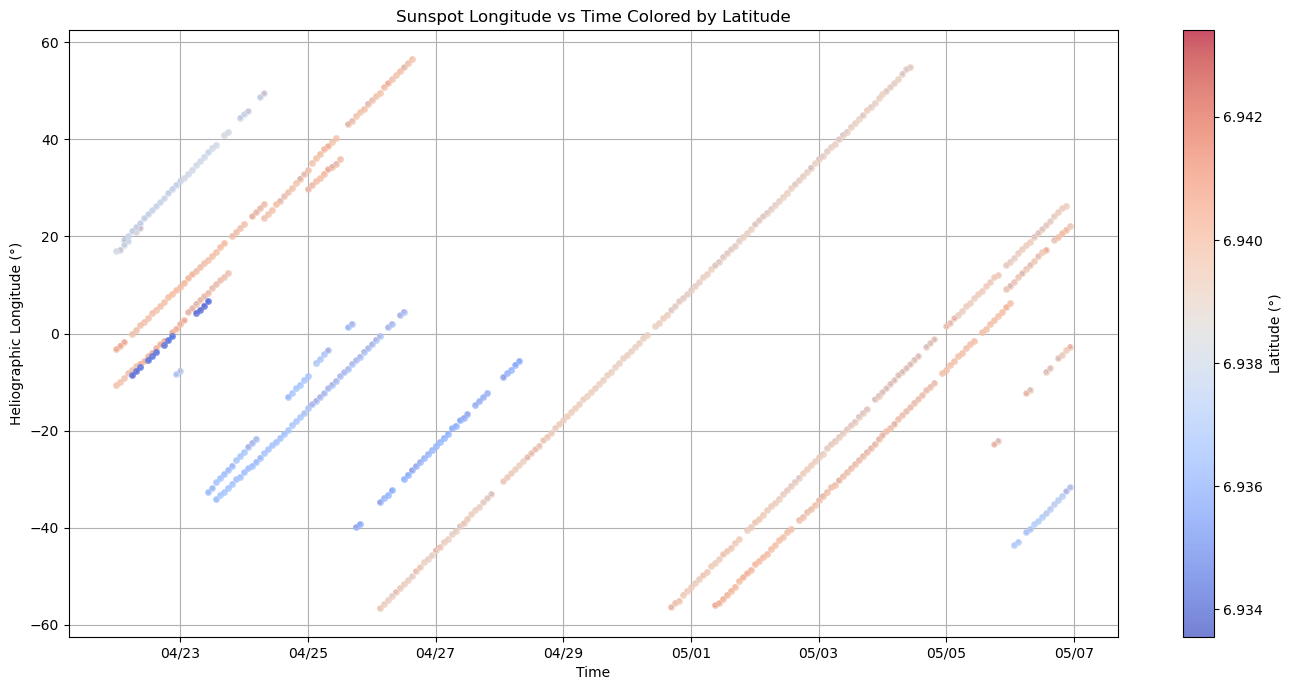

In [11]:
# Plot longitude against time with point color based on latitude
fig, ax = plt.subplots(figsize=(14, 7))
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=-40, vmax=40)  # Latitude range for color mapping

for track in cleaned_data:
    lons = [p.lon.deg for p in track['positions_helio']]
    lats = [p.lat.deg for p in track['positions_helio']]  # for color
    times = track['times']

    sc = ax.scatter(times, lons, c=lats, cmap='coolwarm', s=10, alpha=0.7, edgecolors='none')
    
    for t, lon, lat in zip(times, lons, lats):
        color = cmap(norm(lat))
        ax.errorbar(t, lon, yerr=ANGLE_UNCERTAINTY, fmt='o', color=color, ecolor=color, alpha=0.7, markersize=4)


# Formatting
ax.set_title("Sunspot Longitude vs Time Colored by Latitude")
ax.set_xlabel("Time")
ax.set_ylabel("Heliographic Longitude (°)")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax.grid(True)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Latitude (°)")

plt.tight_layout()
plt.show()


Angular velocity is calculated as:
$$
\omega = \frac{\Delta \theta}{\Delta t}.
$$

By the error propogation formula, this means that our error can be found by:
$$
\delta \omega = \omega \sqrt{\left(\frac{\delta \theta}{\Delta \theta}\right)^{2} + \left(\frac{\delta t}{\Delta t}\right)^{2}}
$$

In [12]:
filtered_tracks = [track for track in cleaned_data if len(track['velocities']) >= 4]
print(f"Number of tracks with more than 4 velocity points is: {len(filtered_tracks)}")

Number of tracks with more than 4 velocity points is: 20


In [13]:
# Filtering through the data to take data every other frame (3 hour cadence)
new_data = []
for track in filtered_tracks:
    new_track = {}
    for key in track.keys():
        new_track[key] = track[key][::2] # The fewer points you take, the lower the error
    new_data.append(new_track)

In [14]:
latitudes = []
for track in filtered_tracks:
    for coord in track['positions_helio']:
        latitudes.append(coord.lat.deg)
max_latitude = max(latitudes)
min_latitude = min(latitudes)
print(f"The solar latitudes from the data are {min_latitude} ~ {max_latitude}")

The solar latitudes from the data are -31.92398318354489 ~ 10.932932944289753


In [15]:
track_summaries = []

for track in new_data:
    times = track['times']
    lons = [p.lon.deg for p in track['positions_helio']]
    lats = [p.lat.deg for p in track['positions_helio']]
    velocities = track['velocities']

    velocity_errors = []
    for i in range(1, len(times)):
        delta_lambda = lons[i] - lons[i-1]
        delta_t_days = (times[i] - times[i-1]).total_seconds() / (3600 * 24)

        if delta_t_days == 0:
            continue

        # Propagate error
        error = velocities[i-1] * np.sqrt(
            (ANGLE_UNCERTAINTY / delta_lambda) ** 2 +
            (DAY_UNCERTAINTY / delta_t_days) ** 2
        )
        velocity_errors.append(error)

    mean_velocity = np.mean(velocities)
    std_velocity = np.std(velocities)
    mean_error = np.mean(velocity_errors)
    median_latitude = np.median(lats)
    
    mean_period = 360 / mean_velocity
    mean_period_error = (mean_error / mean_velocity) * mean_period

    track_summaries.append({
        "mean_period": mean_period,
        "std_velocity": std_velocity,
        "mean_error": mean_error,
        "median_latitude": median_latitude,
        "num_points": len(times)
    })

summary_df = pd.DataFrame(track_summaries)
summary_df


,mean_period,std_velocity,mean_error,median_latitude,num_points
0,28.822681,3.358629,3.357827,-3.451365,14
1,25.602780,4.351005,3.775736,10.285554,14
2,27.614237,1.544177,3.359523,10.529968,18
3,27.311148,0.969014,3.025392,-31.910766,5
4,27.149554,1.782542,3.542805,-12.943442,24
5,25.105500,1.978705,3.866854,-13.204381,6
6,24.938192,1.299441,3.894045,9.874696,10
7,29.646449,0.162104,2.996624,-12.719825,5
8,30.561101,2.271371,3.249719,10.678020,5
9,26.295378,2.579656,3.723192,9.970103,9


In [16]:
std_filtered_tracks = [track for track in track_summaries if track['std_velocity'] < 5]

final_data = std_filtered_tracks


#find the point with lowest longitude and latitude
#remove all points with mean period higher than the max value

# lat_filtered_std_filtered_tracks = sorted(std_filtered_tracks, key = lambda x: abs(x['median_latitude']))
# center_point = std_filtered_tracks[0]

# final_data = [track for track in lat_filtered_std_filtered_tracks if (track['mean_period'] - track['mean_error']) < center_point['mean_period']]
# final_data = [track for track in std_filtered_tracks if track['mean_period'] < 30]


filtered_df = pd.DataFrame(final_data)
filtered_df

,mean_period,std_velocity,mean_error,median_latitude,num_points
0,28.822681,3.358629,3.357827,-3.451365,14
1,25.602780,4.351005,3.775736,10.285554,14
2,27.614237,1.544177,3.359523,10.529968,18
3,27.311148,0.969014,3.025392,-31.910766,5
4,27.149554,1.782542,3.542805,-12.943442,24
5,25.105500,1.978705,3.866854,-13.204381,6
6,24.938192,1.299441,3.894045,9.874696,10
7,29.646449,0.162104,2.996624,-12.719825,5
8,30.561101,2.271371,3.249719,10.678020,5
9,26.295378,2.579656,3.723192,9.970103,9


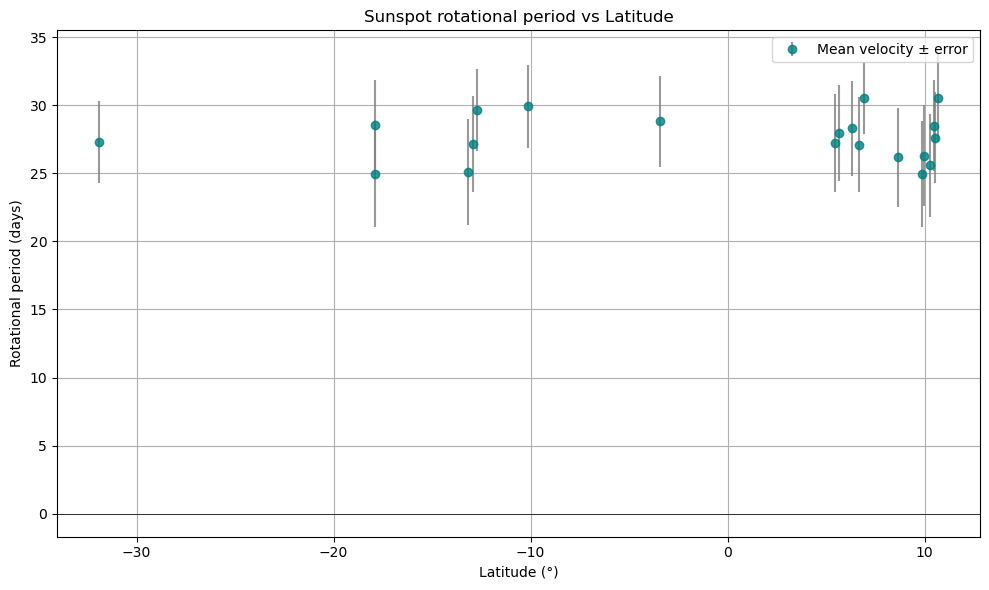

In [17]:
# Plot mean velocity vs median latitude with error bars
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    filtered_df['median_latitude'],
    filtered_df['mean_period'],
    yerr=filtered_df['mean_error'],
    fmt='o',
    color='teal',
    ecolor='gray',
    alpha=0.8,
    label='Mean velocity ± error'
)

ax.set_title("Sunspot rotational period vs Latitude")
ax.set_xlabel("Latitude (°)")
ax.set_ylabel("Rotational period (days)")
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [18]:
track_periods = []
track_errors = []
for track in final_data:
    track_periods.append(track['mean_period'])
    track_errors.append(track['mean_error'])
mean_period = np.mean(track_periods)
mean_error = np.mean(track_errors)

print(f"The calculated period is {mean_period} ± {mean_error} days")

The calculated period is 27.616557390726946 ± 3.4373824492601317 days


Considering the actual solar rotation period varies from 25 days to around 30 days, this calculation seems to work quite well!

But let's try to plot it against a published model.

The hypothetical model to be fit to is this:
$$
\omega(\varphi) = A + B\sin^2(\varphi) + C\sin^4(\varphi)
$$
where $\omega(\varphi)$ is the longitudinal angular velocity, $A,B,C$ are tuneable parameters, and $\varphi$ is the angle in radians of latitude.

The canonical values are:

$A = 14.5$,

$B = -2.8$,

$C = -0.3$.

In [19]:
def latitude_model(phi_deg, A, B, C):
    phi = phi_deg*np.pi/180
    omega = A + B*(np.sin(phi))**2 + C*(np.sin(phi))**4
    return 360/omega

from scipy.optimize import curve_fit

latitudes = filtered_df['median_latitude']
periods = filtered_df['mean_period']
period_errors = filtered_df['mean_error']

popt, pcov = curve_fit(latitude_model, latitudes, periods, sigma=period_errors, absolute_sigma=True)

# popt contains optimal A, B, C
A, B, C = popt

# uncertainties (standard deviation) of A, B, C
A_err, B_err, C_err = np.sqrt(np.diag(pcov))


In [20]:
print(f"fitted points:\nA = {A} ± {A_err},\nB = {B} ± {B_err},\nC = {C} ± {C_err}.")

fitted points:
A = 12.600013892783501 ± 0.6896184433277073,
B = 9.813056041839275 ± 22.198355076308165,
C = -27.649406124335904 ± 76.59691312773282.


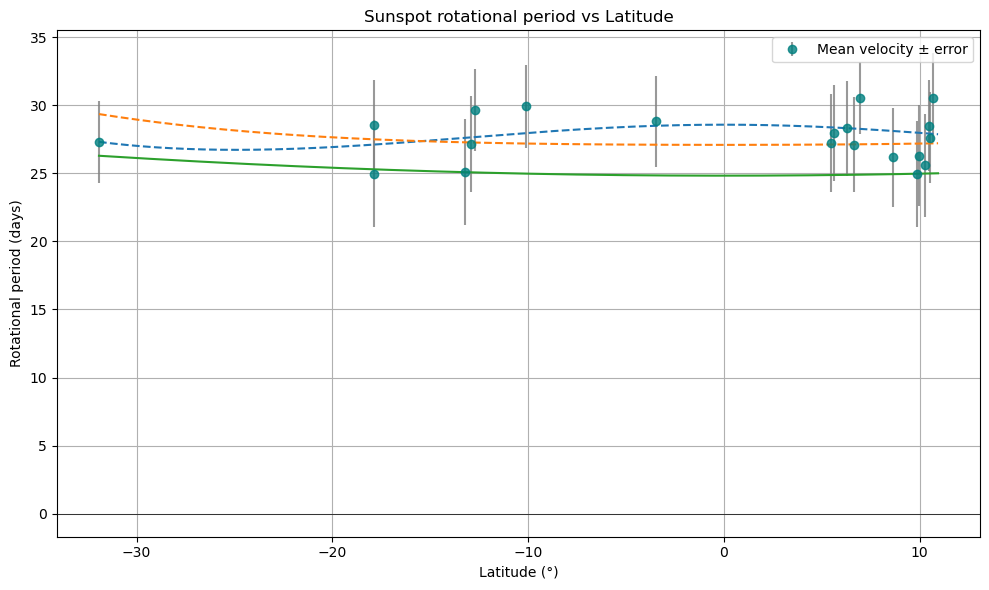

In [ ]:
# Plot mean velocity vs median latitude with error bars
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    filtered_df['median_latitude'],
    filtered_df['mean_period'],
    yerr=filtered_df['mean_error'],
    fmt='o',
    color='teal',
    ecolor='gray',
    alpha=0.8,
    label='Mean velocity ± error'
)

lats = np.linspace(min_latitude,max_latitude,10**3)
model = latitude_model(lats,*popt)
ax.plot(lats,model, '--', label="Best fit from data")

# low_estimate = latitude_model(lats, A-A_err, B-B_err,C-C_err)
# ax.plot(lats,low_estimate,'--')

high_estimate = latitude_model(lats, A+A_err, B-B_err/2,C+C_err/4)
ax.plot(lats, high_estimate, '--', label = "Highest estimate from data")

actual = latitude_model(lats, 14.5, -2.8, -0.3)
ax.plot(lats, actual)


ax.set_title("Sunspot rotational period vs Latitude")
ax.set_xlabel("Latitude (°)")
ax.set_ylabel("Rotational period (days)")
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()